In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, get_scheduler

import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid

import copy
import matplotlib.pyplot as plt

import os

import numpy as np
from collections import Counter
import torch

c:\Users\ivanc\OneDrive - Singapore University of Technology and Design\School Work\Term_8\AI\Project\Depression_detection_project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_df = pd.read_csv("./data/train.tsv", delimiter='\t', index_col=False)
dev_df = pd.read_csv("./data/dev.tsv", delimiter='\t', index_col=False)
test_df = pd.read_csv("./data/test.tsv", delimiter='\t', index_col=False)

In [4]:
train_df['label'] = train_df['label'].apply(lambda x: {'not depression': 0, 'moderate': 1, 'severe': 2}.get(x))
test_df['label'] = test_df['label'].apply(lambda x: {'not depression': 0, 'moderate': 1, 'severe': 2}.get(x))
dev_df['label'] = dev_df['label'].apply(lambda x: {'not depression': 0, 'moderate': 1, 'severe': 2}.get(x))

In [5]:
class RobertaCNNClassifier(nn.Module):
    def __init__(self, model_name="roberta-base", num_filters=128, kernel_size=3, dropout=0.3):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.roberta.config.hidden_size  # usually 768

        self.conv1d = nn.Conv1d(in_channels=self.hidden_size,
                                out_channels=num_filters,
                                kernel_size=kernel_size,
                                padding=1)  # keep same length

        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)  # output shape: (B, num_filters, 1)
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(num_filters, 3)  # 3 class classification

    def forward(self, input_ids, attention_mask):
        # Encode with RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (B, T, H)

        x = last_hidden_state.permute(0, 2, 1)  # (B, H, T)
        x = self.conv1d(x)                      # (B, num_filters, T)
        x = self.relu(x)
        x = self.pool(x)                        # (B, num_filters, 1)
        x = x.squeeze(2)                        # (B, num_filters)

        x = self.dropout(x)
        logits = self.fc(x)                     # (B, 1)
        return logits

In [6]:
class RobertaClassifier(nn.Module):
    def __init__(self, model_name="roberta-base", dropout=0.3):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, 3)  # 3-class classification

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (B, T, H)
        
        cls_rep = last_hidden_state[:, 0, :]  # Take the [CLS] token embedding (B, H), the special token in a Bert model that is used for classification
        x = self.dropout(cls_rep)
        logits = self.classifier(x)           # (B, 3)
        return logits

In [7]:
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8

In [8]:
class DepressionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        '''
        Dataset for labelling sentences with depression.
        '''
        super().__init__()
        self.dataframe = dataframe
        self.inputs = dataframe['text']
        self.outputs = dataframe['label']
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = self.inputs.iloc[idx]
        label = self.outputs.iloc[idx]

        inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(label, dtype=torch.long)
        }

In [9]:
train_dataset = DepressionDataset(train_df, roberta_tokenizer, MAX_LEN)
dev_dataset = DepressionDataset(dev_df, roberta_tokenizer, MAX_LEN)
test_dataset = DepressionDataset(test_df, roberta_tokenizer, MAX_LEN)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE)

## Experiment using weighted Cross entropy

In [13]:
all_train_labels = [sample['targets'].numpy().item() for sample in train_dataset]
counts = Counter(all_train_labels)

In [14]:
counts

Counter({1: 6019, 0: 1971, 2: 901})

In [15]:
## unnormalized class weights

num_classes = 3
total = sum(counts.values())
class_weights = [total / counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [14]:
import os
import copy
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, model_name="Roberta_depression", epochs=3, use_weighted_CE=False, class_weights=None):
    if use_weighted_CE:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    model.to(device)

    best_metric = 0
    avg_train_loss_history = []
    avg_val_loss_history = []

    train_acc_history = []
    val_acc_history = []
    train_f1_history = []
    val_f1_history = []

    patience = 2
    epochs_no_improve = 0
    best_model_state = None
    best_per_class_f1 = None

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # --- Training ---
        model.train()
        train_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_train_loss = train_loss / len(train_loader)

        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        avg_train_loss_history.append(avg_train_loss)

        print(f"Train Loss: {train_loss / len(train_loader):.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['ids'].to(device)
                attention_mask = batch['mask'].to(device)
                labels = batch['targets'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        per_class_f1 = f1_score(val_labels, val_preds, average=None)
        avg_val_loss = val_loss / len(val_loader)

        val_acc_history.append(val_acc)
        val_f1_history.append(val_f1)
        avg_val_loss_history.append(avg_val_loss)

        print(f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
        print(f"Per class F1: {per_class_f1}")

        # --- Early stopping logic ---
        if val_f1 > best_metric:
            best_metric = val_f1
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            best_per_class_f1 = per_class_f1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch+1} — no F1 improvement in {patience} epochs.")
                break

    # --- Save Best Model ---
    final_model_path = f'models/{model_name}_{best_metric:.4f}_best.pt'
    if best_model_state:
        os.makedirs("models", exist_ok=True)
        torch.save(best_model_state, final_model_path)
        print(f"✅ Best model saved as {final_model_path}")

    # --- Plotting ---
    os.makedirs("plots", exist_ok=True)
    plot_filename = f'{model_name}_metrics_plot.png'
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    epochs_range = list(range(1, len(train_acc_history) + 1))

    # Left: Training loss over time (every batch)
    axs[0].plot(epochs_range, avg_train_loss_history, label='Train Loss')
    axs[0].plot(epochs_range, avg_val_loss_history, label='Val Loss')
    axs[0].set_title('Train and Val Loss (per epoch)')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)
    axs[0].legend()

    # Right: Accuracy and F1 (per epoch)
    axs[1].plot(epochs_range, train_acc_history, label='Train Accuracy')
    axs[1].plot(epochs_range, val_acc_history, label='Val Accuracy')
    axs[1].plot(epochs_range, train_f1_history, label='Train F1')
    axs[1].plot(epochs_range, val_f1_history, label='Val F1')
    axs[1].set_title('Accuracy and F1 Score')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Score')
    axs[1].grid(True)
    axs[1].legend()

    # ✅ Add per-class F1 text box in the second plot
    f1_text = "\n".join([f"Class {i}: {f1:.2f}" for i, f1 in enumerate(per_class_f1)])
    axs[1].text(1.05, 0.5, f"Per-Class F1 (last epoch):\n{f1_text}",
                transform=axs[1].transAxes,
                fontsize=10,
                verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", edgecolor="gray"))

    plt.tight_layout()
    plt.savefig(os.path.join("plots", plot_filename))
    print(f"📈 Plot saved as {plot_filename}")
    plt.show()

    return model, best_metric


Vanilla roberta training

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:46<00:00,  3.88it/s]


Train Loss: 0.5537 | Acc: 0.7954 | F1: 0.6515
Val Loss: 1.0497 | Acc: 0.5743 | F1: 0.4304
Per class F1: [0.26952947 0.70135243 0.32046332]

Epoch 2/8


100%|██████████| 1112/1112 [04:49<00:00,  3.85it/s]


Train Loss: 0.2945 | Acc: 0.8976 | F1: 0.8517
Val Loss: 1.1069 | Acc: 0.5854 | F1: 0.5166
Per class F1: [0.45203969 0.67771029 0.42004773]

Epoch 3/8


100%|██████████| 1112/1112 [04:49<00:00,  3.84it/s]


Train Loss: 0.1914 | Acc: 0.9330 | F1: 0.9059
Val Loss: 1.1685 | Acc: 0.5351 | F1: 0.5015
Per class F1: [0.53080274 0.58000896 0.39361702]

Epoch 4/8


100%|██████████| 1112/1112 [04:50<00:00,  3.83it/s]


Train Loss: 0.1157 | Acc: 0.9598 | F1: 0.9430
Val Loss: 1.3995 | Acc: 0.5509 | F1: 0.5136
Per class F1: [0.50497912 0.61129848 0.4246696 ]
⏹️ Early stopping triggered at epoch 4 — no F1 improvement in 2 epochs.
✅ Best model saved as models/RobertaClassifier_0.5166_best.pt
📈 Plot saved as RobertaClassifier_metrics_plot.png


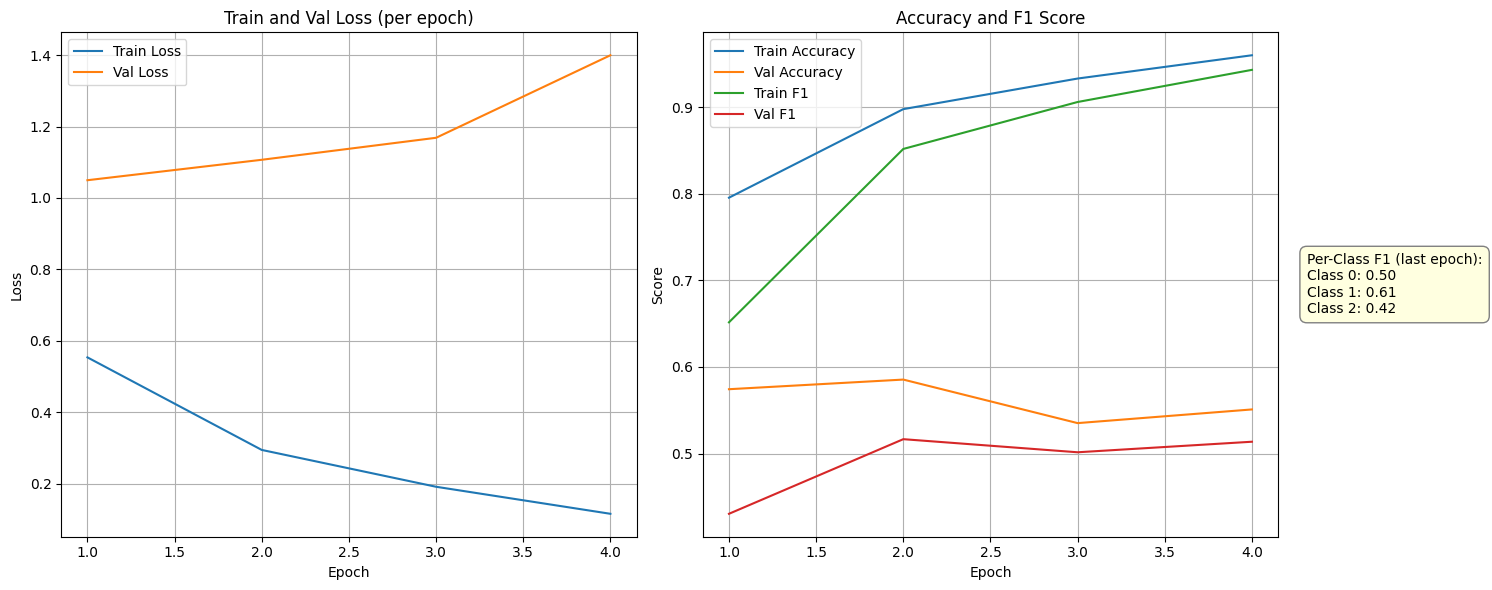

(RobertaClassifier(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
   

In [17]:
roberta_classifier = RobertaClassifier()
num_epochs = 8
lr = 1e-5

optimizer = torch.optim.AdamW(roberta_classifier.parameters(), lr=lr)
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)
train_model(roberta_classifier, 
            train_loader=train_dataloader, 
            val_loader=dev_dataloader,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            model_name="RobertaClassifier",
            epochs=num_epochs)

Run experiment helper class for Roberta CNN

In [15]:
def run_experiment(params, train_dataset, val_dataset, device, model_name='model', num_epochs=8, class_weights=None):
    model_name = (
    f"{model_name}_nf{params['num_filters']}_"
    f"ks{params['kernel_size']}_"
    f"do{int(params['dropout'] * 100)}_"
    f"lr{str(params['lr']).replace('.', '')}_"
)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

    # Create model
    model = RobertaCNNClassifier(
        num_filters=params['num_filters'],
        kernel_size=params['kernel_size'],
        dropout=params['dropout']
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])
    scheduler = get_scheduler(
        "linear", optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )
    
    if class_weights != None:
        return train_model(model, train_loader, val_loader, optimizer, scheduler, device, model_name=model_name, epochs=num_epochs, use_weighted_CE=True, class_weights=class_weights)
    else:
        return train_model(model, train_loader, val_loader, optimizer, scheduler, device, model_name=model_name, epochs=num_epochs)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:54<00:00,  3.77it/s]


Train Loss: 0.5670 | Acc: 0.7921 | F1: 0.6543
Val Loss: 0.9219 | Acc: 0.5692 | F1: 0.4862
Per class F1: [0.39333604 0.67606136 0.38918919]

Epoch 2/8


100%|██████████| 1112/1112 [04:58<00:00,  3.73it/s]


Train Loss: 0.3176 | Acc: 0.8956 | F1: 0.8508
Val Loss: 0.9419 | Acc: 0.5612 | F1: 0.5168
Per class F1: [0.4976239  0.63140765 0.42123894]

Epoch 3/8


100%|██████████| 1112/1112 [04:58<00:00,  3.72it/s]


Train Loss: 0.2150 | Acc: 0.9266 | F1: 0.8999
Val Loss: 1.2062 | Acc: 0.5214 | F1: 0.4808
Per class F1: [0.48328691 0.59276696 0.36627505]

Epoch 4/8


100%|██████████| 1112/1112 [04:49<00:00,  3.83it/s]


Train Loss: 0.1388 | Acc: 0.9540 | F1: 0.9384
Val Loss: 1.1529 | Acc: 0.5460 | F1: 0.5141
Per class F1: [0.52105897 0.59079062 0.43045113]
⏹️ Early stopping triggered at epoch 4 — no F1 improvement in 2 epochs.
✅ Best model saved as models/roberta_cnn_nf128_ks4_do40_lr1e-05__0.5168_best.pt
📈 Plot saved as roberta_cnn_nf128_ks4_do40_lr1e-05__metrics_plot.png


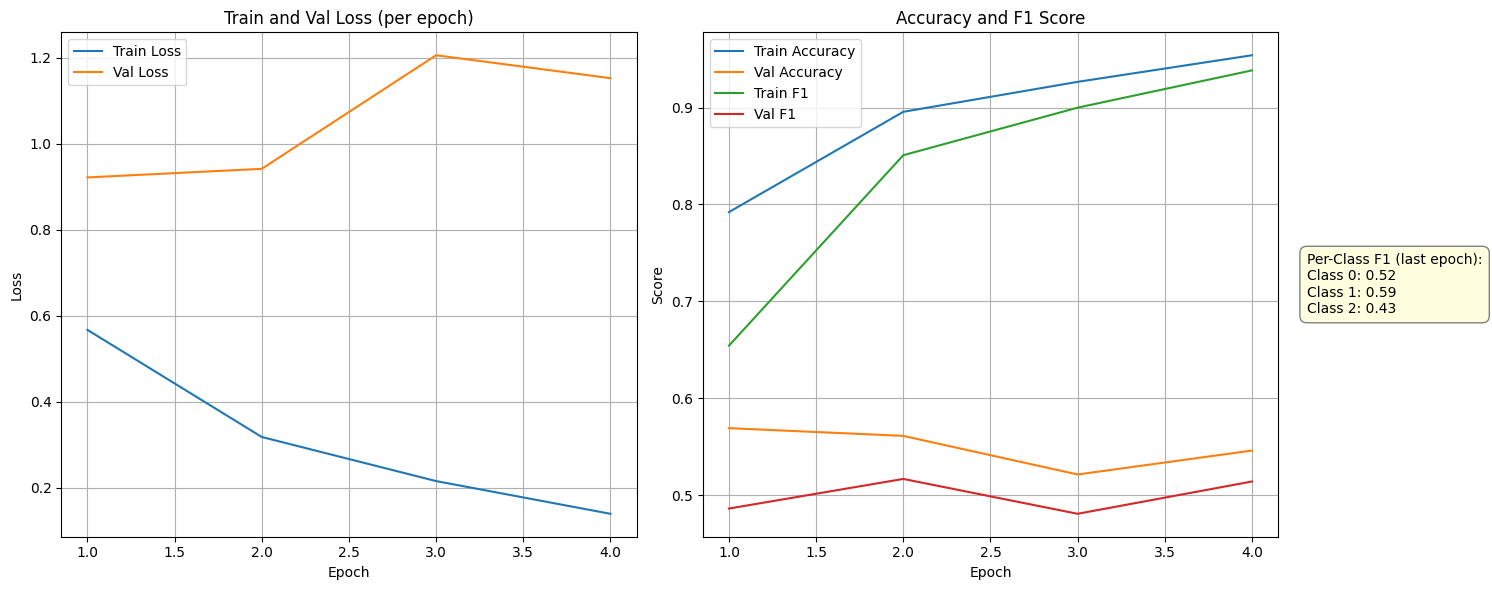

(RobertaCNNClassifier(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)


In [14]:
params = {'dropout': 0.4, 'kernel_size': 4, 'lr': 1e-05, 'num_filters': 128}

run_experiment(params, train_dataset, dev_dataset, device)

## Roberta CNN with weighted CE

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:50<00:00,  3.83it/s]


Train Loss: 0.7377 | Acc: 0.7062 | F1: 0.6263
Val Loss: 0.9805 | Acc: 0.5391 | F1: 0.4860
Per class F1: [0.45746269 0.62733293 0.37321294]

Epoch 2/8


100%|██████████| 1112/1112 [04:50<00:00,  3.82it/s]


Train Loss: 0.4121 | Acc: 0.8639 | F1: 0.8193
Val Loss: 1.1459 | Acc: 0.4982 | F1: 0.4701
Per class F1: [0.53239256 0.5343802  0.34350688]

Epoch 3/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.2645 | Acc: 0.9126 | F1: 0.8852
Val Loss: 1.1634 | Acc: 0.5407 | F1: 0.5092
Per class F1: [0.61304736 0.4766639  0.43798883]

Epoch 4/8


100%|██████████| 1112/1112 [04:48<00:00,  3.86it/s]


Train Loss: 0.1874 | Acc: 0.9398 | F1: 0.9258
Val Loss: 1.3387 | Acc: 0.5343 | F1: 0.4999
Per class F1: [0.58096828 0.54438738 0.37433155]

Epoch 5/8


100%|██████████| 1112/1112 [04:47<00:00,  3.86it/s]


Train Loss: 0.1278 | Acc: 0.9595 | F1: 0.9500
Val Loss: 1.3427 | Acc: 0.5494 | F1: 0.5168
Per class F1: [0.56446585 0.57261602 0.41342756]

Epoch 6/8


100%|██████████| 1112/1112 [04:47<00:00,  3.86it/s]


Train Loss: 0.0911 | Acc: 0.9721 | F1: 0.9643
Val Loss: 1.6456 | Acc: 0.5209 | F1: 0.4926
Per class F1: [0.54786451 0.54159793 0.38847858]

Epoch 7/8


100%|██████████| 1112/1112 [04:48<00:00,  3.86it/s]


Train Loss: 0.0724 | Acc: 0.9778 | F1: 0.9709
Val Loss: 1.5802 | Acc: 0.5472 | F1: 0.5090
Per class F1: [0.52276981 0.59935275 0.40486533]
⏹️ Early stopping triggered at epoch 7 — no F1 improvement in 2 epochs.
✅ Best model saved as models/RobertaCNNWeightedLoss_64_ks3_do40_lr1e-05__0.5168_best.pt
📈 Plot saved as RobertaCNNWeightedLoss_64_ks3_do40_lr1e-05__metrics_plot.png


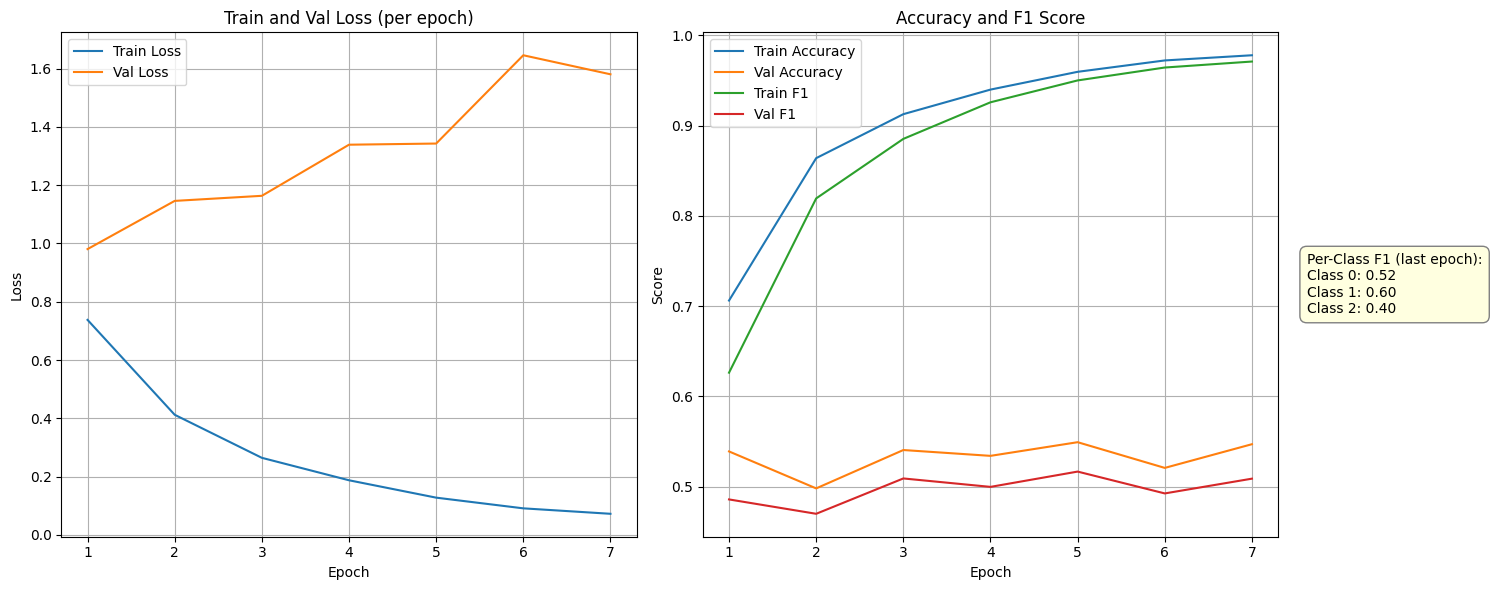

(RobertaCNNClassifier(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)


In [18]:
params = {'dropout': 0.4, 'kernel_size': 3, 'lr': 1e-05, 'num_filters': 64}

run_experiment(params, train_dataset, dev_dataset, device, "RobertaCNNWeightedLoss", num_epochs=8, class_weights=class_weights)

## Hyperparameter tuning with Roberta CNN

In [16]:
param_grid = {
    'num_filters': [64],
    'kernel_size': [3],
    'dropout': [0.1, 0.3, 0.5],
    'lr': [2e-5, 5e-6],
}

grid = list(ParameterGrid(param_grid))



Running config 1/6: {'dropout': 0.1, 'kernel_size': 3, 'lr': 2e-05, 'num_filters': 64}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:51<00:00,  3.81it/s]


Train Loss: 0.5183 | Acc: 0.8119 | F1: 0.6989
Val Loss: 1.0718 | Acc: 0.5625 | F1: 0.4598
Per class F1: [0.30327144 0.68550161 0.39072039]

Epoch 2/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.2735 | Acc: 0.9065 | F1: 0.8689
Val Loss: 0.9856 | Acc: 0.5839 | F1: 0.5281
Per class F1: [0.48069289 0.66807774 0.43554688]

Epoch 3/8


100%|██████████| 1112/1112 [04:48<00:00,  3.86it/s]


Train Loss: 0.1649 | Acc: 0.9459 | F1: 0.9259
Val Loss: 1.2106 | Acc: 0.5725 | F1: 0.5228
Per class F1: [0.52799457 0.64402568 0.39638158]

Epoch 4/8


100%|██████████| 1112/1112 [04:51<00:00,  3.81it/s]


Train Loss: 0.1081 | Acc: 0.9663 | F1: 0.9538
Val Loss: 1.5044 | Acc: 0.5427 | F1: 0.4909
Per class F1: [0.47510669 0.62589195 0.37176471]
⏹️ Early stopping triggered at epoch 4 — no F1 improvement in 2 epochs.
✅ Best model saved as models/model_nf64_ks3_do10_lr2e-05__0.5281_best.pt
📈 Plot saved as model_nf64_ks3_do10_lr2e-05__metrics_plot.png


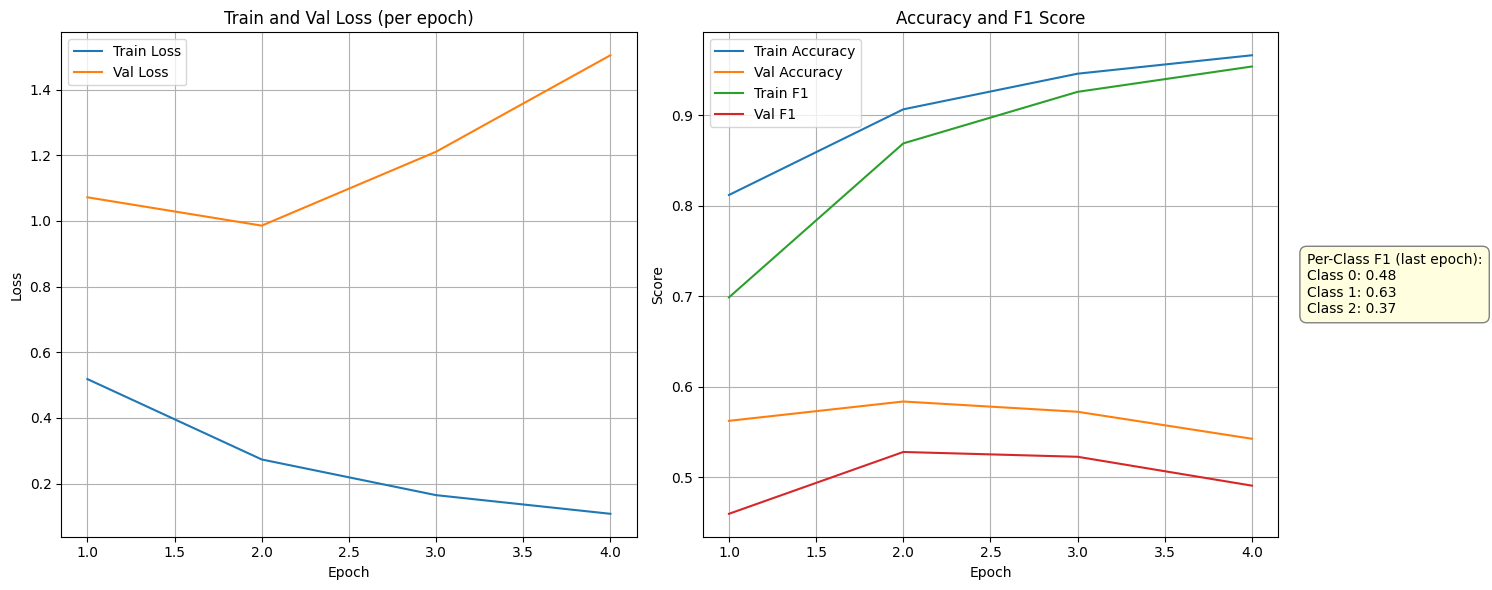


Running config 2/6: {'dropout': 0.1, 'kernel_size': 3, 'lr': 5e-06, 'num_filters': 64}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.6294 | Acc: 0.7628 | F1: 0.5403
Val Loss: 1.0214 | Acc: 0.5901 | F1: 0.4837
Per class F1: [0.38772213 0.6991511  0.36421725]

Epoch 2/8


100%|██████████| 1112/1112 [04:53<00:00,  3.78it/s]


Train Loss: 0.3597 | Acc: 0.8752 | F1: 0.8087
Val Loss: 0.9999 | Acc: 0.5314 | F1: 0.4764
Per class F1: [0.44579227 0.62387161 0.35938641]

Epoch 3/8


100%|██████████| 1112/1112 [04:53<00:00,  3.78it/s]


Train Loss: 0.2552 | Acc: 0.9127 | F1: 0.8735
Val Loss: 1.1238 | Acc: 0.5636 | F1: 0.4918
Per class F1: [0.42266824 0.66629381 0.38638454]

Epoch 4/8


100%|██████████| 1112/1112 [04:53<00:00,  3.79it/s]


Train Loss: 0.1787 | Acc: 0.9408 | F1: 0.9141
Val Loss: 1.0831 | Acc: 0.5781 | F1: 0.5244
Per class F1: [0.50722204 0.65221714 0.4137931 ]

Epoch 5/8


100%|██████████| 1112/1112 [04:53<00:00,  3.79it/s]


Train Loss: 0.1366 | Acc: 0.9535 | F1: 0.9336
Val Loss: 1.2550 | Acc: 0.5425 | F1: 0.5059
Per class F1: [0.58117714 0.56226054 0.37413395]

Epoch 6/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.1050 | Acc: 0.9654 | F1: 0.9502
Val Loss: 1.2443 | Acc: 0.5781 | F1: 0.5297
Per class F1: [0.52641815 0.64376278 0.41887906]

Epoch 7/8


100%|██████████| 1112/1112 [04:53<00:00,  3.79it/s]


Train Loss: 0.0858 | Acc: 0.9730 | F1: 0.9615
Val Loss: 1.3005 | Acc: 0.5536 | F1: 0.5123
Per class F1: [0.53337342 0.60356057 0.4       ]

Epoch 8/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.0687 | Acc: 0.9795 | F1: 0.9709
Val Loss: 1.4357 | Acc: 0.5438 | F1: 0.5043
Per class F1: [0.51488953 0.60154573 0.39636664]
⏹️ Early stopping triggered at epoch 8 — no F1 improvement in 2 epochs.
✅ Best model saved as models/model_nf64_ks3_do10_lr5e-06__0.5297_best.pt
📈 Plot saved as model_nf64_ks3_do10_lr5e-06__metrics_plot.png


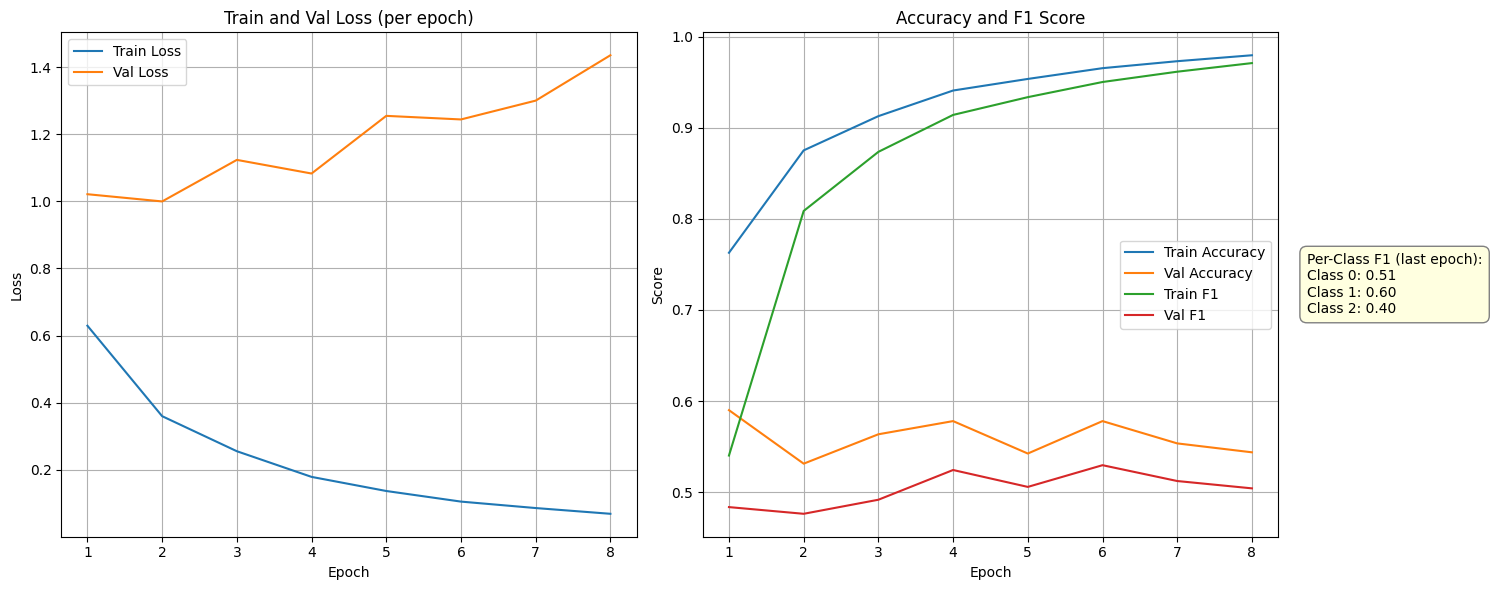


Running config 3/6: {'dropout': 0.3, 'kernel_size': 3, 'lr': 2e-05, 'num_filters': 64}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:52<00:00,  3.81it/s]


Train Loss: 0.5483 | Acc: 0.7966 | F1: 0.6527
Val Loss: 1.0583 | Acc: 0.5512 | F1: 0.4618
Per class F1: [0.31285904 0.67202797 0.40039643]

Epoch 2/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.3167 | Acc: 0.8918 | F1: 0.8433
Val Loss: 0.9881 | Acc: 0.5565 | F1: 0.5059
Per class F1: [0.51716095 0.62151067 0.37890974]

Epoch 3/8


100%|██████████| 1112/1112 [04:53<00:00,  3.78it/s]


Train Loss: 0.2012 | Acc: 0.9309 | F1: 0.9028
Val Loss: 0.9984 | Acc: 0.5598 | F1: 0.5187
Per class F1: [0.50644628 0.62476742 0.42477876]

Epoch 4/8


100%|██████████| 1112/1112 [05:56<00:00,  3.12it/s]


Train Loss: 0.1319 | Acc: 0.9577 | F1: 0.9428
Val Loss: 1.1784 | Acc: 0.5463 | F1: 0.5103
Per class F1: [0.57993562 0.55574203 0.39524245]

Epoch 5/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.0801 | Acc: 0.9745 | F1: 0.9655
Val Loss: 1.3068 | Acc: 0.5694 | F1: 0.5308
Per class F1: [0.54124022 0.61636287 0.43487395]

Epoch 6/8


100%|██████████| 1112/1112 [04:52<00:00,  3.81it/s]


Train Loss: 0.0578 | Acc: 0.9832 | F1: 0.9761
Val Loss: 1.5281 | Acc: 0.5721 | F1: 0.5365
Per class F1: [0.55510675 0.61152335 0.44279661]

Epoch 7/8


100%|██████████| 1112/1112 [04:51<00:00,  3.81it/s]


Train Loss: 0.0430 | Acc: 0.9876 | F1: 0.9830
Val Loss: 1.5845 | Acc: 0.5512 | F1: 0.5171
Per class F1: [0.55688456 0.57796068 0.41642229]

Epoch 8/8


100%|██████████| 1112/1112 [04:52<00:00,  3.80it/s]


Train Loss: 0.0309 | Acc: 0.9907 | F1: 0.9870
Val Loss: 1.7716 | Acc: 0.5596 | F1: 0.5178
Per class F1: [0.53238302 0.61273153 0.4082397 ]
⏹️ Early stopping triggered at epoch 8 — no F1 improvement in 2 epochs.
✅ Best model saved as models/model_nf64_ks3_do30_lr2e-05__0.5365_best.pt
📈 Plot saved as model_nf64_ks3_do30_lr2e-05__metrics_plot.png


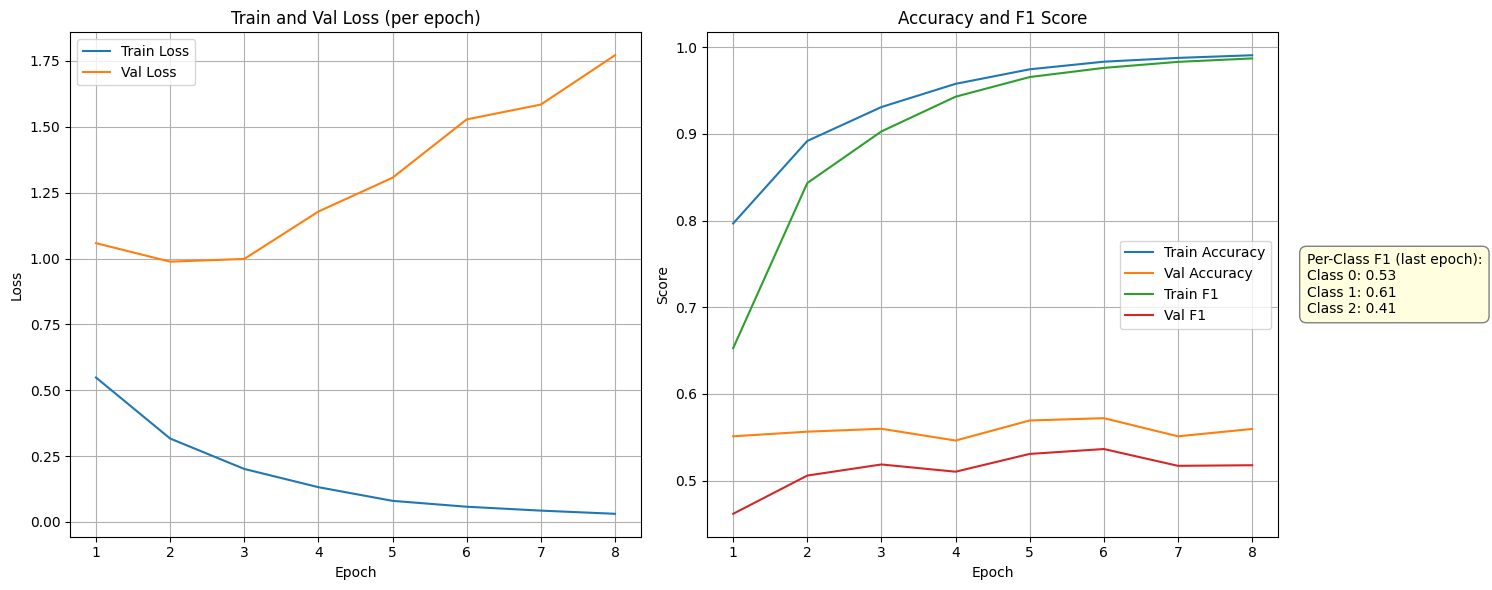


Running config 4/6: {'dropout': 0.3, 'kernel_size': 3, 'lr': 5e-06, 'num_filters': 64}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


100%|██████████| 1112/1112 [04:53<00:00,  3.79it/s]


Train Loss: 0.6623 | Acc: 0.7478 | F1: 0.5132


KeyboardInterrupt: 

In [17]:
best_f1 = 0
best_params = None

for i, params in enumerate(grid):
    print(f"\nRunning config {i + 1}/{len(grid)}: {params}")
    model, val_f1 = run_experiment(params, train_dataset=train_dataset, val_dataset=dev_dataset, device=device)
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = params

print(f"\nBest F1: {best_f1:.4f} with params: {best_params}")


In [11]:
def test_model(model, test_dataloader):
        criterion = nn.CrossEntropyLoss()

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch in test_dataloader:
                input_ids = batch['ids'].to(device)
                attention_mask = batch['mask'].to(device)
                labels = batch['targets'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        print(f"Test Acc: {val_acc:.4f} | Test F1: {val_f1:.4f}")

In [12]:
# Base roberta
model_path = "./models/RobertaClassifier_0.5166_best.pt"
model_to_test = RobertaClassifier()
# model_to_test = RobertaCNNClassifier(num_filters=64, kernel_size=3, dropout=0.4)
model_to_test.load_state_dict(torch.load(model_path))
model_to_test.to(device)
test_model(model_to_test, test_dataloader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Acc: 0.6370 | Test F1: 0.5060


In [13]:
# roberta weighted loss
model_path = "./models/RobertaCNNWeightedLoss_nf64_ks3_do40_lr1e-05__0.5168_best.pt"
# model_to_test = RobertaClassifier()
model_to_test = RobertaCNNClassifier(num_filters=64, kernel_size=3, dropout=0.4)
model_to_test.load_state_dict(torch.load(model_path))
model_to_test.to(device)
test_model(model_to_test, test_dataloader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Acc: 0.5294 | Test F1: 0.4677


In [17]:
model_path = "./models/roberta_cnn_nf64_ks3_do30_lr2e-05__0.5365_best.pt"
# model_to_test = RobertaClassifier()
model_to_test = RobertaCNNClassifier(num_filters=64, kernel_size=3, dropout=0.4)
model_to_test.load_state_dict(torch.load(model_path))
model_to_test.to(device)
test_model(model_to_test, test_dataloader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Acc: 0.5569 | Test F1: 0.4980


In [20]:
models_to_test = [
    'roberta_cnn_nf64_ks3_do10_lr2e-05__0.5281_best.pt',
    'roberta_cnn_nf64_ks3_do10_lr5e-06__0.5297_best.pt',
    'roberta_cnn_nf64_ks3_do30_lr2e-05__0.5365_best.pt',
    'roberta_cnn_nf64_ks3_do40_lr1e-05__0.5361_best.pt',
]

for model_name in models_to_test:
    model_path = f"./models/{model_name}"
    # model_to_test = RobertaClassifier()
    model_to_test = RobertaCNNClassifier(num_filters=64, kernel_size=3, dropout=0.4)
    model_to_test.load_state_dict(torch.load(model_path))
    model_to_test.to(device)
    print(model_name)
    test_model(model_to_test, test_dataloader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta_cnn_nf64_ks3_do10_lr2e-05__0.5281_best.pt
Test Acc: 0.6052 | Test F1: 0.5012


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta_cnn_nf64_ks3_do10_lr5e-06__0.5297_best.pt
Test Acc: 0.5917 | Test F1: 0.4989


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta_cnn_nf64_ks3_do30_lr2e-05__0.5365_best.pt
Test Acc: 0.5569 | Test F1: 0.4980


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta_cnn_nf64_ks3_do40_lr1e-05__0.5361_best.pt
Test Acc: 0.6579 | Test F1: 0.5139


In [16]:

model_path = './models/roberta_cnn_nf128_ks3_do40_lr1e-05__0.5304_best.pt'
# model_to_test = RobertaClassifier()
model_to_test = RobertaCNNClassifier(num_filters=128, kernel_size=3, dropout=0.4)
model_to_test.load_state_dict(torch.load(model_path))
model_to_test.to(device)
test_model(model_to_test, test_dataloader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Acc: 0.6385 | Test F1: 0.4982


In [17]:
model_path = './models/roberta_cnn_nf128_ks4_do40_lr1e-05__0.5168_best.pt'
model_to_test = RobertaCNNClassifier(num_filters=128, kernel_size=4, dropout=0.4)
model_to_test.load_state_dict(torch.load(model_path))
model_to_test.to(device)
test_model(model_to_test, test_dataloader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Acc: 0.5723 | Test F1: 0.4875


goal is to beat
f1: 0.583
accuracy: 0.671

In [22]:
def predict_depression_multiclass(text, model, tokenizer, max_len=128, device=device):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=1)  # shape: (1, 3)
        pred_class = torch.argmax(probs, dim=1).item()

    return pred_class, probs.squeeze().tolist()


In [23]:
# saved_model = RobertaCNNClassifier()
saved_model = RobertaCNNClassifier(num_filters=64, kernel_size=3, dropout=0.4)
saved_model.load_state_dict(torch.load('./models/RobertaCNNWeightedLoss_64_ks3_do40_lr1e-05__0.5168_best.pt'))
saved_model.to(device=device)
text = "I feel nothing about this life, there is nothing worth living for, everyday is just a bleak miserable existence"

saved_model.eval()
label, prob = predict_depression_multiclass(text, saved_model, roberta_tokenizer)

print(f"Prediction: {label} (probability of depression = {prob})")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction: 1 (probability of depression = [0.2993870973587036, 0.4248182475566864, 0.27579465508461])
